## Correlation: FFDI ~ LDsss (1950/51 to 2015/16) - Fire paper - Figure 1 - false discovery rate

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
from pathlib import Path

%matplotlib inline

In [2]:
# Load FFDI NDJF average netcdf (calculated in FFDI_LDsss_correlation_v2)
ds_fire = xr.open_dataset('/g/data1a/v45/du2523/Monthly_calcs/FFDI_4mSeason_NDJF.nc')
ds_fire = ds_fire.where(ds_fire.monthlyFFDI > 0, drop = True) #remove grid points from ocean
ds_fire

0.3.0


<xarray.Dataset>
Dimensions:      (time: 70, lat: 640, lon: 808)
Coordinates:
  * time         (time) datetime64[ns] 1951-02-28 1952-02-29 ... 2020-02-29
  * lat          (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.85 -10.8 -10.75
  * lon          (lon) float32 113.2 113.3 113.3 113.4 ... 153.5 153.6 153.6
Data variables:
    monthlyFFDI  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [3]:
#subset to period covered by ice core
FFDI_subset = ds_fire.sel(time = slice('1951-02-28','2016-02-29'))

In [4]:
#load LDsss text file
#LDsss data stored here: https://data.aad.gov.au/metadata/DSS_2k_data_compilation
import pandas as pd

LDsss = pd.read_csv('/g/data1a/v45/du2523/ice_core_data/LawDome_DSS/LDsss_DJFM_1900_2016_vOct21_Jongetal.csv',
                   parse_dates=['JanYear'],
                   dayfirst = True)
#remove top row to match length with fire dataset
LDsss = LDsss.iloc[51:]

LDsss.head()

,JanYear,LDsss_DJFM
51,1951-01-01,0.217781
52,1952-01-01,0.244258
53,1953-01-01,0.170617
54,1954-01-01,0.138624
55,1955-01-01,0.135459


In [5]:
#set up parameters to create xarray dataset from LDsss timeseries

Year = LDsss['JanYear']
npdates = Year.to_numpy()

lons = FFDI_subset.lon.values
lats = FFDI_subset.lat.values

LDsss_dates_col = LDsss.loc[:,'JanYear']
LDsss_dates = LDsss_dates_col.values

LDsss_conc_col = LDsss.loc[:,'LDsss_DJFM']
LDsss_conc = LDsss_conc_col.values
LDsss_conc.size

66

In [6]:
#Replicate dataset shape and fill with ice core data - FFDI dataset is time, lat, lon
nlons = lons.size
nlats = lats.size
ntime = LDsss_dates.size

LDsss_arr = np.zeros((ntime,nlats,nlons))
LDsss_fill = np.zeros((ntime,nlats,nlons))

n = LDsss_dates.size
for i in range(n):
    x = LDsss_conc[i]
    tmp = LDsss_arr[i,:,:]
    tmp[tmp == 0] = x
    LDsss_fill[[i]] = tmp

LDsss_fill.shape

(66, 640, 808)

In [8]:
#extract time from netcdf dataset to match for correlation
dates = FFDI_subset.time
dates.shape

dates_extend = ds_fire.time
dates_extend.shape

(70,)

In [9]:
#create an xarray dataset from the LDsss timeseries - using time, lat, lon from the netcdf dataset

ds_icecore = xr.Dataset({
    'LDsss':xr.DataArray(
        data = LDsss_fill, #enter data here - array must be the same size as the time, lat, lon dims/coords
        dims = ["time","lat","lon"],
        coords = {'time': dates,
                 'lat': lats,
                 'lon': lons},
        attrs = {
            '_FillValue':-999.9,
            'units': 'logCl'
        }
    )
}
)
ds_icecore

<xarray.Dataset>
Dimensions:  (time: 66, lat: 640, lon: 808)
Coordinates:
  * time     (time) datetime64[ns] 1951-02-28 1952-02-29 ... 2016-02-29
  * lat      (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.85 -10.8 -10.75
  * lon      (lon) float32 113.2 113.3 113.3 113.4 ... 153.4 153.5 153.6 153.6
Data variables:
    LDsss    (time, lat, lon) float64 0.2178 0.2178 0.2178 ... 0.3387 0.3387

In [12]:
#save netcdf
#ds_icecore.to_netcdf('/g/data/v45/du2523/FFDI_condition_counts/LDsss_1951-2016.nc')

In [10]:
#slice datasets to be the same length
LDsss = ds_icecore.LDsss.sel(time = slice('1951-02-28','2016-02-29'))
FFDI = ds_fire.monthlyFFDI.sel(time = slice('1951-02-28','2016-02-29')) 

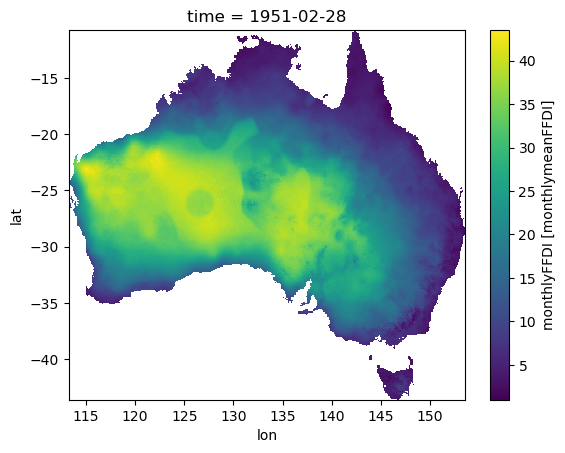

In [17]:
#plot one season - check dataset
FFDI.sel(time = '1951-02-28').plot()

## Detrend

In [11]:
#Detrend function

def detrend_dim(da, dim, deg = 1):
    #detrend along a single dimension
    p = da.polyfit(dim = dim, deg = deg)
    fit = xr.polyval(da[dim],p.polyfit_coefficients)
    return da - fit

In [12]:
dFFDI = detrend_dim(FFDI,"time",1)
dLDsss = detrend_dim(LDsss,"time",1)

In [13]:
#check datasets are the same shape
print(dLDsss.shape , dFFDI.shape)

(66, 640, 808) (66, 640, 808)


## Pearson Correlation (spatial)

In [14]:
import xskillscore as xs
import warnings
warnings.filterwarnings("ignore")

In [15]:
#correlation with xskillscore
dcorr_r = xs.pearson_r(dLDsss, dFFDI, dim = "time", skipna = True)

In [16]:
#p value accounting for temporal autocorrelation
dcorr_eff_p = xs.pearson_r_eff_p_value(dLDsss, dFFDI, dim = "time", skipna = True)

In [17]:
# pa value - no autocorrelation
dcorr_p = xs.pearson_r_p_value(dLDsss, dFFDI, dim = "time", skipna = True)

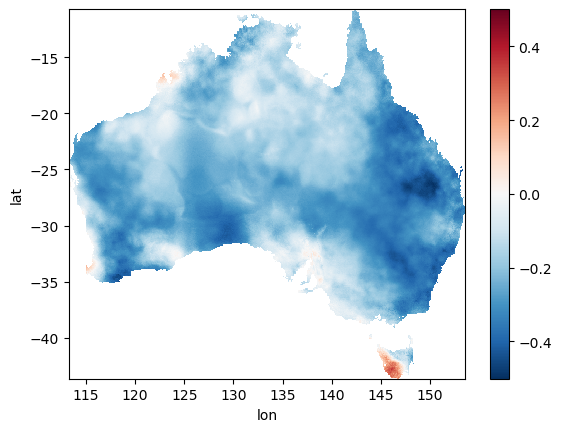

In [18]:
#plot correlation results
dcorr_r.plot()

In [20]:
#Calculate the False Discovery Rates - multiple tests
p_df = dcorr_eff_p.to_dataframe(name = 'pvalues')
r_df = dcorr_r.to_dataframe(name = 'r')
p_df = p_df.dropna(axis = 0)
p_df_sorted = p_df.sort_values(by = ['pvalues'])
r_df = r_df.dropna(axis = 0)
r_df_sorted = r_df.sort_values(by = ['r'])
r_df_sorted.head()

r
lat        lon                 
-26.650000 150.399994 -0.501240
-26.549999 150.500000 -0.499097
-26.350000 150.350006 -0.498422
           150.300003 -0.497372
-26.449999 150.399994 -0.497200

In [21]:
#merge dataframes
df_r_p = pd.concat([r_df_sorted, p_df_sorted], axis = 1)
df_r_p.head()

r   pvalues
lat        lon                           
-26.650000 150.399994 -0.501240  0.000018
-26.549999 150.500000 -0.499097  0.000023
-26.350000 150.350006 -0.498422  0.000024
           150.300003 -0.497372  0.000025
-26.449999 150.399994 -0.497200  0.000022

In [24]:
#extract pvals column
pvals = df_r_p.iloc[:,1]
pvals.shape

(278132,)

In [26]:
#qvals
import statsmodels.api as sm
qvals = sm.stats.multipletests(pvals, alpha = 0.05, method = "fdr_bh")
qvals[1]
df_r_p['qvals'] = qvals[1]
df_r_p.head()

r   pvalues    qvals
lat        lon                                    
-26.650000 150.399994 -0.501240  0.000018  0.03345
-26.549999 150.500000 -0.499097  0.000023  0.03345
-26.350000 150.350006 -0.498422  0.000024  0.03345
           150.300003 -0.497372  0.000025  0.03345
-26.449999 150.399994 -0.497200  0.000022  0.03345

In [27]:
#save to csv
df_r_p.to_csv('/g/data/v45/du2523/Fire_paper_scripts_figures/LDsss_FFDI_r_peff_qvals.csv')

In [67]:
#subset dataframe to qvals <0.05
qval_lt_0pt05 = df_r_p[df_r_p['qvals']<0.05]
qval_lt_0pt05

r   pvalues     qvals
lat        lon                                     
-26.650000 150.399994 -0.501240  0.000018  0.033450
-26.549999 150.500000 -0.499097  0.000023  0.033450
-26.350000 150.350006 -0.498422  0.000024  0.033450
           150.300003 -0.497372  0.000025  0.033450
-26.449999 150.399994 -0.497200  0.000022  0.033450
...                         ...       ...       ...
-42.750000 146.149994  0.352002  0.003750  0.034522
-42.799999 145.949997  0.355385  0.003409  0.034138
-42.750000 146.100006  0.357682  0.003442  0.034166
-42.849998 146.149994  0.360483  0.002946  0.033728
-42.799999 146.100006  0.365191  0.002570  0.033610

[54955 rows x 3 columns]

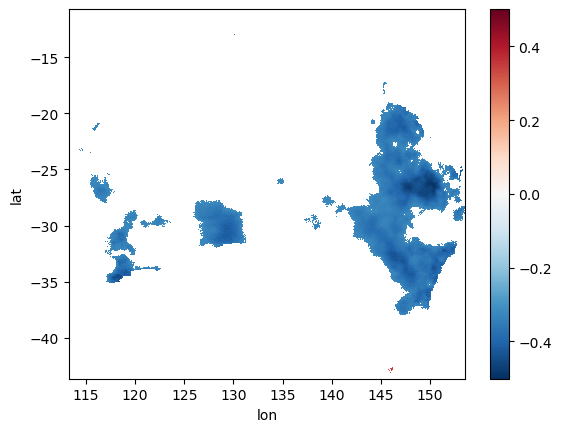

In [28]:
#adjusted significance accounting for multiple testing
#qval = 0.05 = pval = 0.009879 = r = -0.31545

dcorr_r.where(dcorr_eff_p<0.009879).plot()

In [30]:
#max/min correlation scores
maxcorr = dcorr_r.max().values
mincorr = dcorr_r.min().values
mincorr, maxcorr

(array(-0.50123992), array(0.36519141))

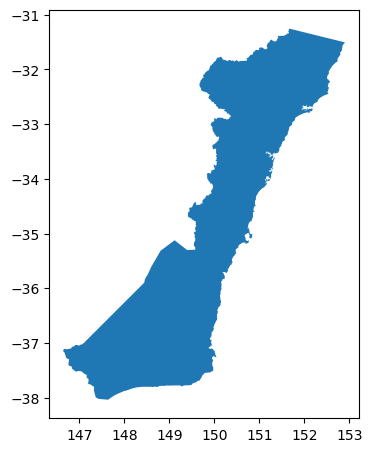

In [31]:
#add polygon of reconstruction region
#geospatial plots
from rasterstats import zonal_stats
import rasterio
import os
import geopandas as gpd

shpfile = gpd.read_file('/g/data1a/v45/du2523/shp_files/ESB_lines_ACT_and_VicAlps_added_Hunter_Lakes_Entrance_valid_geometry.shp')
#remove none rows
shp = shpfile
shp = shp[shp.geom_type == 'MultiPolygon']

fig, ax = plt.subplots(figsize = (4,8))
shp.plot(ax = ax)
plt.show()

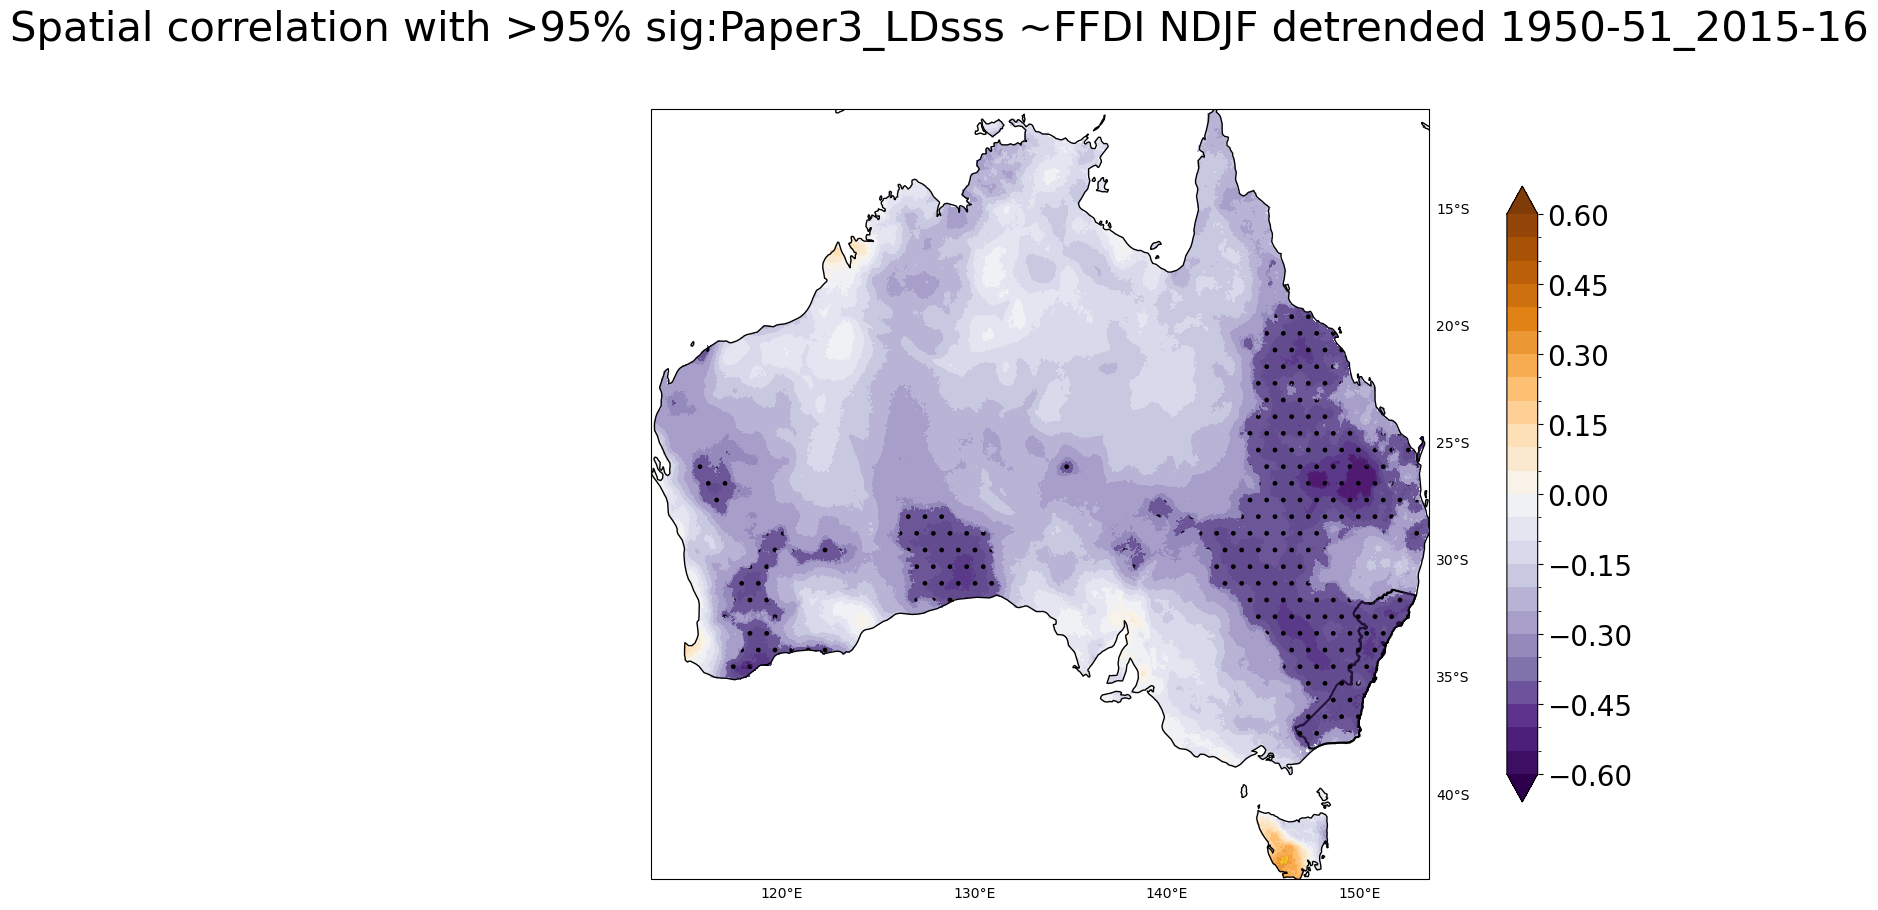

In [32]:
#signficance calculation above
corr = dcorr_r
sig_corr = dcorr_r.where(dcorr_eff_p<0.009879) #accounting for false discovery rate
x = sig_corr.lon
y = sig_corr.lat
z = sig_corr

output = '/g/data/v45/du2523/Fire_paper_scripts_figures/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

levels = np.arange(-0.6,0.65,0.05)
var = 'Paper3_LDsss'
period = '1950-51_2015-16'
ID = 'FFDI_corr_NDJF_detrend_temp_spat_autocorr_sig95_FDR'
region = 'Aus'

cp = corr.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'both',
                        cmap = 'PuOr_r',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

shp.plot(ax = ax, color = 'none', edgecolor = 'black', linewidth = 1.5)

hatch = ax.contourf(x,y,z, hatches=['.'],extend = 'both', alpha = 0.5)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)
    
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.01, color='grey', alpha=0.1, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Spatial correlation with >95% sig:'+ var + ' ~FFDI NDJF detrended ' + period,fontsize = 30)

#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.pdf', format = "pdf")